In [1]:
# Perform the initialization and imports
import sys
import pickle
import re
import os
import csv
import argparse
import math
import pprint

from string import ascii_lowercase
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO, AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio.Emboss.Applications import NeedleallCommandline

# Demand Python 3.
if sys.version_info[0] < 3:
    print("Python 3 is required, but you are using Python %i.%i.%i") % (
        sys.version_info[0], sys.version_info[1], sys.version_info[2])
    sys.exit(1)

In [2]:
# Retrieve the specific functions from ind and proteins.py
indels_path="/home/mp/InDelScanner"  # /PATH/TO/InDelScanner
if indels_path not in sys.path:
    sys.path.append(indels_path)
from indels.ind import trim_read, findEnds, endMatch, findGap, gapAlign
from ipynb.fs.defs.F01_Library_diversity import convert_variant_to_dict, single_fraction_enrichment

In [3]:
os.chdir("/mnt/c/Users/Maya/Documents/03_Kinases/code_check")

with open('mek.pickle', 'rb') as f:
    mek = pickle.load(f)

with open('kinases_all_ref.pickle', 'rb') as f:
    all_ref = pickle.load(f)

In [4]:
# Set general restrictions stemming from SpliMLib library design
aa_2 = ['A', 'Δ']
aa_12 = ['A','G','P','Y','D','K','M','V','I','L','F','W']
aa_13 = aa_12 +  ['Δ']
splimlib = {'6': aa_12, '9': aa_12, '11': aa_12, '13': aa_12, '7a': aa_13, '8a': aa_2}

### Examine the combined enrichment distributions

In [5]:
df_all = pd.DataFrame.from_dict(mek).fillna(0).sort_values(by=['high', 'med', 'low-t'], ascending=False)

In [6]:
df_all.describe()

,high,med,low-t
count,829144.000000,829144.000000,829144.000000
mean,5.738704,3.741781,8.380919
std,31.848957,9.404503,9.271202
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000
50%,0.000000,0.000000,6.000000
75%,0.000000,1.000000,13.000000
max,1185.000000,232.000000,453.000000


In [7]:
cols = ['mediumseagreen', 'gold', 'salmon']

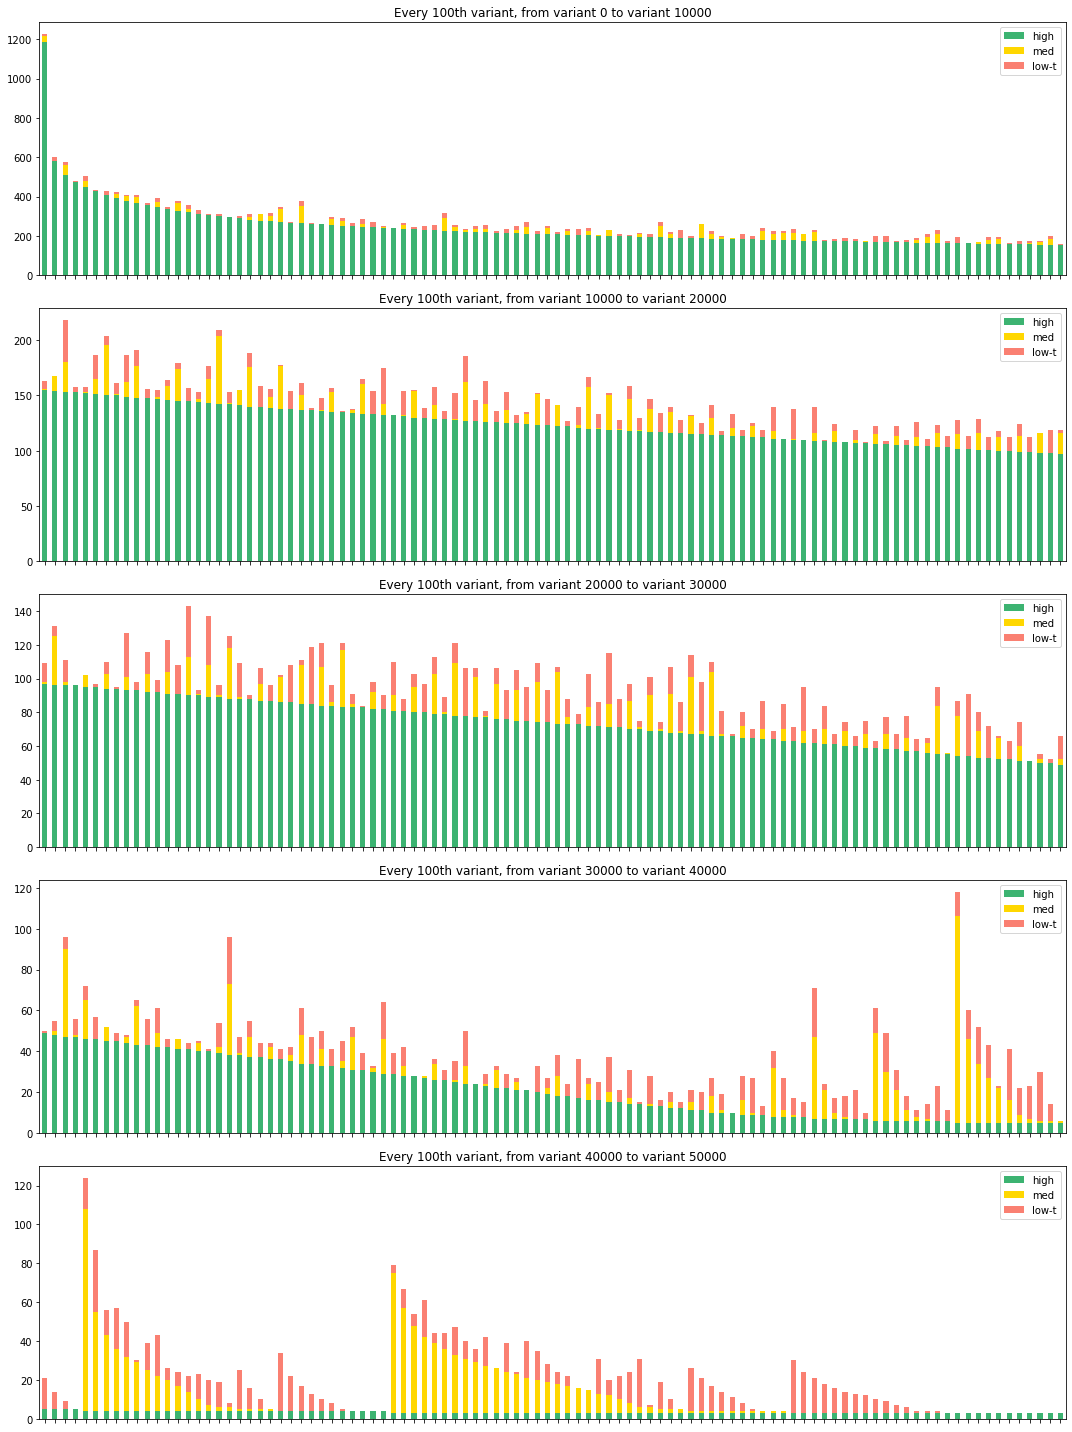

In [8]:
split = 10000
n=5

fig, axes = plt.subplots(n, 1,figsize=(15,4*n))

for p in range(len(axes)):
    df_all.iloc[p*split:(p+1)*split:100].plot.bar(stacked=True, ax=axes[p], color = cols)
    
    axes[p].axes.get_xaxis().set_ticklabels([])
    title = 'Every 100th variant, from variant ' + str(p*split) + ' to variant ' + str((p+1)*split)
    axes[p].set_title(title, position=(0.5, 0.9))


plt.tight_layout()
# plt.savefig('Read_distribution.png', dpi=300)

plt.show()

The probability that a variant is truly 'active' decreases going down the plots, with a clear trend:
- the top 10K variants are 'active' with a high confidence, the appearance of variants in the medium and low gates is just experimental noise
- with some more variability, the same can be said for the next 10-20Ks variants, shown on the second plot. This covers variants with 100+ High reads
- looking at the last two plots, there is a high degree of variability in read distribution once we reach <20 reads in high gate. There, further investigation is needed. Two avenues: check the variants from 20K onwards at higher resolution to pin down the cutoff high gate count, and b) take the variants with fewer high counts below that and re-sort according to medium gate distribution. Especially in the less active variants that become the dominant factor.

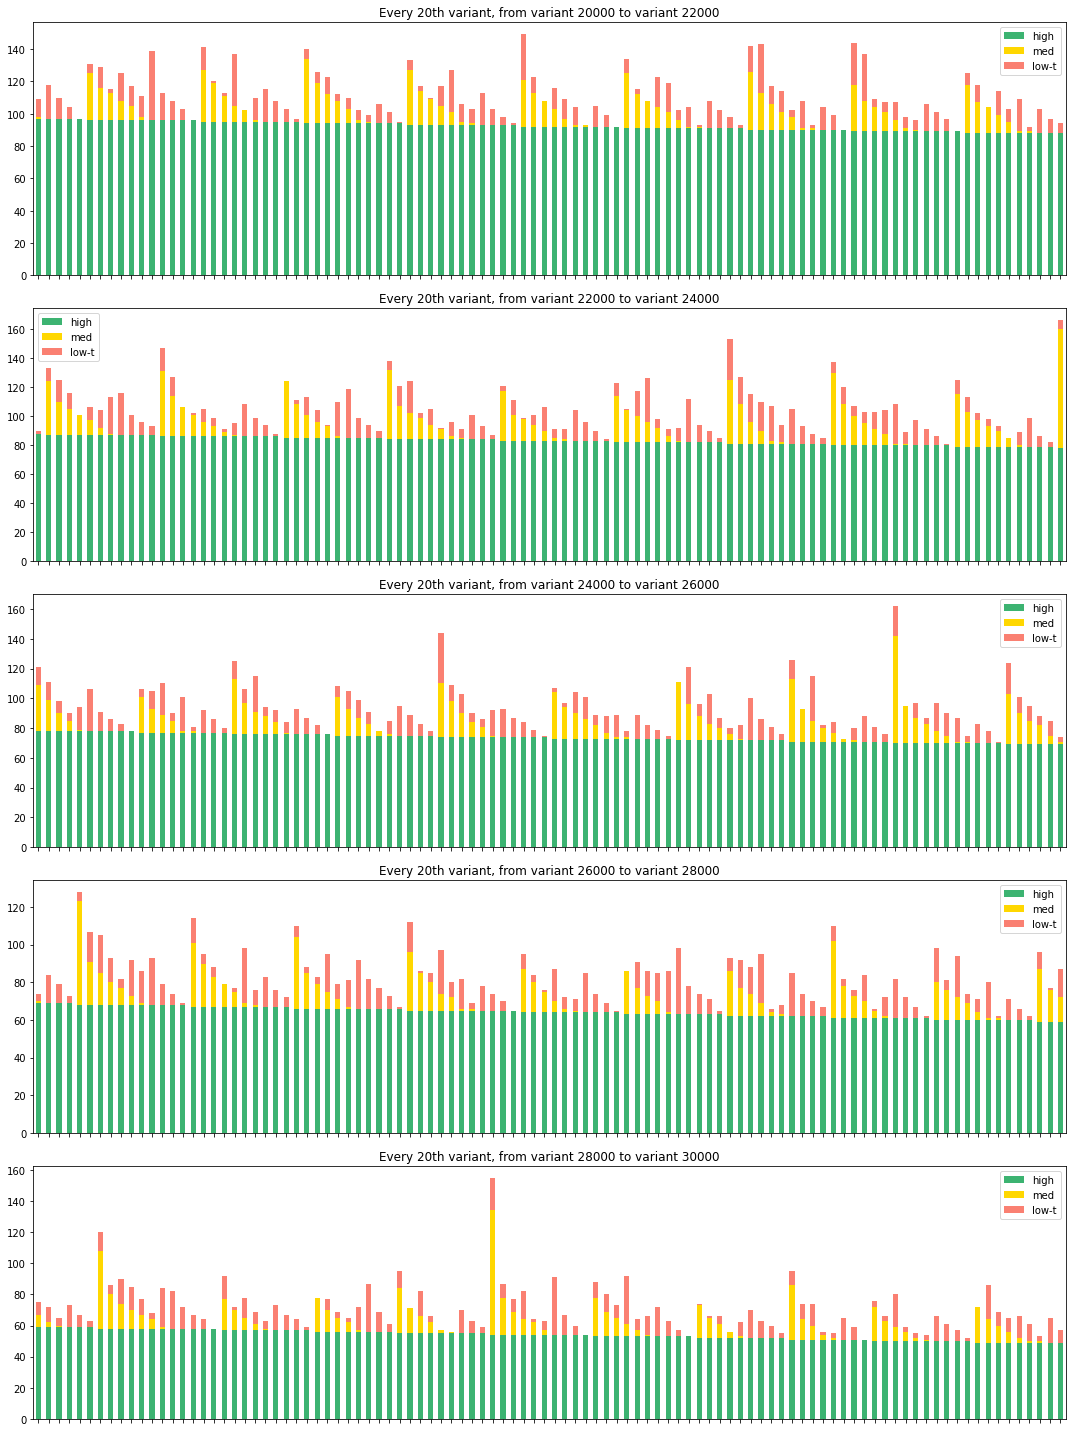

In [9]:
os = 20000
split = 2000
n=5

fig, axes = plt.subplots(n, 1,figsize=(15,4*n))

for p in range(len(axes)):
    df_all.iloc[os+p*split:os+(p+1)*split:20].plot.bar(stacked=True, ax=axes[p], color = cols)
    
    axes[p].axes.get_xaxis().set_ticklabels([])
    title = 'Every 20th variant, from variant ' + str(os+p*split) + ' to variant ' + str(os+(p+1)*split)
    axes[p].set_title(title, position=(0.5, 0.9))


plt.tight_layout()

plt.show()

These plots show that from variant 20K to variant 30K there is increasing variation in the frequencies in medium and low gates. On the whole, the precise activity level for some of the variants is less clear-cut because some are equally or more frequent in the medium gate - are they 'active' and depleted from the sort? Or are they truly less active variants?

#### Where does the WT appear?

In [10]:
df_all.loc['6P/9I/11L/13P']

high     51.0
med      36.0
low-t    34.0
Name: 6P/9I/11L/13P, dtype: float64

In [11]:
df_all.loc['6P/9I/11L/13P']/df_all.loc['6P/9I/11L/13P'].sum()

high     0.421488
med      0.297521
low-t    0.280992
Name: 6P/9I/11L/13P, dtype: float64

#### Conservative choice for activity
The cutoff criteria for variants to be considered active are built based on WT:
- 51 or more reads in high bin
- more reads in high than in low bin
- more reads in high than in medium bin
- 42% or more reads total in high bin

In [12]:
df_51p = df_all.loc[(df_all['high'] >= 51)]
df_51p.describe()

,high,med,low-t
count,29603.000000,29603.000000,29603.000000
mean,146.213931,11.612810,11.432895
std,87.679320,15.697705,10.396649
min,51.000000,0.000000,0.000000
25%,87.000000,0.000000,5.000000
50%,123.000000,3.000000,10.000000
75%,177.000000,19.000000,16.000000
max,1185.000000,232.000000,453.000000


In [13]:
df_pos = df_all.loc[(df_all['high'] >= 51) & (df_all['high'] > df_all['low-t']) & (df_all['high'] > df_all['med']) &
                   (df_all['high'] > 0.42*(df_all['high'] + df_all['med'] + df_all['low-t']))]
# this filtering removed 35 variants based on H>L, H>M condition and 4 based on %H. Leaves one variants with a stop codon.

Next, we drop a few more variants from this dataset to use a WT-like threshold for activity.

In [14]:
df_pos[df_pos.index.str.contains('*', regex=False)]

,high,med,low-t
6L/7aI/9A/9a*,53.0,24.0,23.0


In [15]:
df_pos = df_pos.drop(['6L/7aI/9A/9a*'])

In [16]:
df_pos.describe()

,high,med,low-t
count,29563.000000,29563.000000,29563.000000
mean,146.294524,11.512363,11.300274
std,87.695445,15.393163,8.303405
min,51.000000,0.000000,0.000000
25%,87.000000,0.000000,5.000000
50%,123.000000,3.000000,10.000000
75%,177.000000,19.000000,16.000000
max,1185.000000,136.000000,80.000000


Here, the filtering steps have been completed: the result is a dataset with 29,5K variants that we are confident to call active MEK1 variants. Next, I use these variants to explore the enrichment of different amino acids amongst positive variants.

In [17]:
df_pos.to_csv('df_pos.csv')

### Where are the single mutants?

In [18]:
aa_2 = ['A', 'Δ']
aa_12 = ['A','G','P','Y','D','K','M','V','I','L','F','W']
aa_13 = aa_12 +  ['Δ']
pos_aa = {'6': aa_12, '9': aa_12, '11': aa_12, '13': aa_12, '7a': aa_13, '8a': aa_2}

In [19]:
# hamming distance = 0 if the aa matches at all positions
def hamming_distance(s1, s2, splimlib):
    d = 0
    if (len(s1) != len(splimlib)) or (len(s2) != len(splimlib)):
        d += 1

    for p in splimlib.keys():
        if s1[p] != s2[p]:
            d += 1
    return d

In [20]:
wt_short = '6P/9I/11L/13P'
wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}

In [21]:
positive_vars = df_pos.index.tolist()

In [22]:
n_single = 0
single_pos_muts = []
for short in positive_vars:
    s = convert_variant_to_dict(short)
    h_dis = hamming_distance(s, wt, wt)
    if h_dis in [0,1]:
        n_single += 1
        single_pos_muts.append(short)
print(n_single)

14


6: P,I = 2

7a: Δ,L,K = 3

9: I,P,F = 3

11: F,L,M,I = 4

13: P,I,L,W,V,F = 6


So the max number of additive variants would be 432 variants



In [23]:
2*3*3*4*6

432

### Check what reads distribution is in the other point mutants

In total, 57 point mutants relative to MKK1 wt sequence are possible. Of those, we observe 13 in the curated dataset.

In [24]:
11+12+1+11+11+11

57

In [25]:
single_pos_muts

['6P/9I/11F/13P',
 '6P/9I/11L/13I',
 '6P/9I/11L/13L',
 '6P/7aL/9I/11L/13P',
 '6P/9P/11L/13P',
 '6P/9F/11L/13P',
 '6P/7aK/9I/11L/13P',
 '6P/9I/11L/13W',
 '6P/9I/11M/13P',
 '6I/9I/11L/13P',
 '6P/9I/11L/13V',
 '6P/9I/11I/13P',
 '6P/9I/11L/13F',
 '6P/9I/11L/13P']

In [26]:
def format_point_mutant(short):
    position_order = ['6', '7a', '8a', '9', '11', '13']
    
    m_by_pos = convert_variant_to_dict(short)
    aa_sequence_shorthand = []
    for p in position_order:
        if m_by_pos[p] == 'Δ':
            aa_sequence_shorthand.append('-')
        else:
            aa_sequence_shorthand.append(m_by_pos[p])
    return ''.join(aa_sequence_shorthand)

In [27]:
def add_nice_labels(df):
    df['short'] = df.index 
    df['fig_format'] = df['short'].apply(format_point_mutant)
    return df

In [28]:
point_high_df = add_nice_labels(df_pos[df_pos.index.isin(single_pos_muts)])

/home/mp/miniconda3/envs/InDelScanner/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/mp/miniconda3/envs/InDelScanner/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


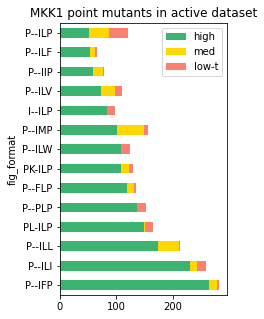

In [29]:
fig, ax = plt.subplots(1, 1,figsize=(3,5))
point_high_df.plot.barh(stacked=True, ax=ax, color=cols, 
                        x='fig_format' ,title='MKK1 point mutants in active dataset')
#plt.savefig('Point_mutants_active_h.svg', transparent=True)
plt.show()

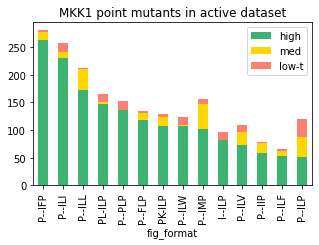

In [30]:
fig, ax = plt.subplots(1, 1,figsize=(5,3))
point_high_df.plot.bar(stacked=True, ax=ax, color=cols, 
                       x='fig_format', title='MKK1 point mutants in active dataset')
#plt.savefig('Point_mutants_active.svg', transparent=True)
plt.show()

In [31]:
def variant_is_allowed(m_by_pos, pos_aa):
    if len(m_by_pos) != len(pos_aa):
        return False
    for p, aa in m_by_pos.items():
        if aa not in pos_aa[p]:
            return False
    return True

In [32]:
all_vars = df_all.index.tolist()

n_neg_single = 0
single_neg_muts = []
for short in all_vars:
    s = convert_variant_to_dict(short)
    # check that it's not a sequencing error
    if not variant_is_allowed(s, pos_aa):
        continue
    
    h_dis = hamming_distance(s, wt, wt)  
    if h_dis == 1:
        if short not in single_pos_muts:
            n_neg_single += 1
            single_neg_muts.append(short)
            
print(n_neg_single)

43


In [33]:
print(single_neg_muts)

['6P/9I/11W/13P', '6P/9L/11L/13P', '6P/9M/11L/13P', '6P/9I/11L/13A', '6L/9I/11L/13P', '6P/9I/11L/13M', '6P/7aM/9I/11L/13P', '6P/9I/11L/13G', '6F/9I/11L/13P', '6V/9I/11L/13P', '6P/9I/11V/13P', '6P/9Y/11L/13P', '6P/7aI/9I/11L/13P', '6K/9I/11L/13P', '6P/7aA/9I/11L/13P', '6A/9I/11L/13P', '6P/9V/11L/13P', '6P/7aV/9I/11L/13P', '6Y/9I/11L/13P', '6P/9A/11L/13P', '6D/9I/11L/13P', '6P/9I/11P/13P', '6P/9I/11Y/13P', '6P/7aW/9I/11L/13P', '6P/9I/11K/13P', '6G/9I/11L/13P', '6P/9I/11L/13K', '6P/8aA/9I/11L/13P', '6W/9I/11L/13P', '6P/9I/11L/13D', '6M/9I/11L/13P', '6P/7aP/9I/11L/13P', '6P/9I/11L/13Y', '6P/9D/11L/13P', '6P/9I/11A/13P', '6P/7aG/9I/11L/13P', '6P/9I/11D/13P', '6P/7aD/9I/11L/13P', '6P/9G/11L/13P', '6P/9K/11L/13P', '6P/7aF/9I/11L/13P', '6P/9I/11G/13P', '6P/9W/11L/13P']


In [34]:
point_low_df = add_nice_labels(df_all[df_all.index.isin(single_neg_muts)])

/home/mp/miniconda3/envs/InDelScanner/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/mp/miniconda3/envs/InDelScanner/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


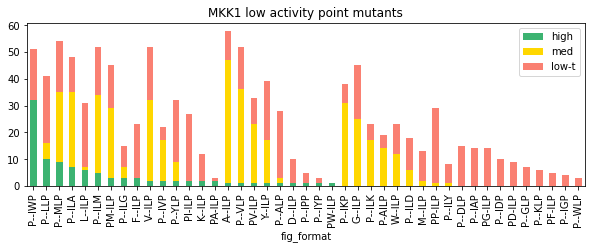

In [35]:
fig, ax = plt.subplots(1, 1,figsize=(10,3))
point_low_df.plot.bar(stacked=True, ax=ax, color= cols, 
                      x='fig_format', title='MKK1 low activity point mutants')

# plt.xticks(rotation=45)
# plt.savefig('Point_mutants_inactive.svg', transparent=True)
plt.show()

In [36]:
57-13-43

1

That leaves only a single point mutant unaccounted for.

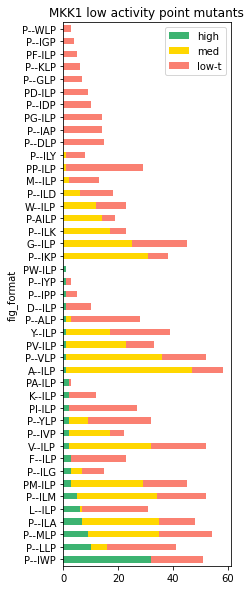

In [37]:
fig, ax = plt.subplots(1, 1,figsize=(3,10))
point_low_df.plot.barh(stacked=True, ax=ax, color=cols,
                       x='fig_format', title='MKK1 low activity point mutants')
#plt.savefig('Point_mutants_inactive.svg', transparent=True)
plt.show()

## Set up clean, full dataset for MAVE NN

In [38]:
def is_variant_in_expected_set(m_by_pos, splimlib):
    for k, a in m_by_pos.items():
        if k not in splimlib.keys():
            return False
        elif a not in splimlib[k]:
            return False
    return True

In [39]:
df_all.describe()

,high,med,low-t
count,829144.000000,829144.000000,829144.000000
mean,5.738704,3.741781,8.380919
std,31.848957,9.404503,9.271202
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000
50%,0.000000,0.000000,6.000000
75%,0.000000,1.000000,13.000000
max,1185.000000,232.000000,453.000000


In [40]:
df_all.head()

,high,med,low-t
6L/7aI/8aA/9L/11F/13M,1185.0,33.0,6.0
6F/7aP/9W/11L/13M,903.0,81.0,15.0
6L/7aF/9L/11I/13I,899.0,2.0,8.0
6A/7aI/8aA/9L/11L/13I,893.0,3.0,19.0
6W/7aI/9F/11L/13V,880.0,34.0,20.0


In [41]:
wt_short = '6P/9I/11L/13P'
wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}

H_dist = {}
for n in df_all.index:
    s1 = convert_variant_to_dict(n)
    H_dist[n] = hamming_distance(wt, s1, splimlib)

In [42]:
df_all.loc[(lambda df_all: df_all['high'] >= 10) or (lambda df_all: df_all['med'] >= 5) or (lambda df_all: df_all['low-t'] >= 3), :].describe()

,high,med,low-t
count,36702.000000,36702.000000,36702.000000
mean,123.726473,10.460384,11.073021
std,91.317521,14.809720,9.908472
min,10.000000,0.000000,0.000000
25%,62.000000,0.000000,5.000000
50%,105.000000,3.000000,10.000000
75%,161.000000,17.000000,15.000000
max,1185.000000,232.000000,453.000000


In [43]:
l = df_all.loc[lambda df: df['low-t'] >= 3, :]
m = df_all.loc[lambda df: df['med'] >= 5, :]
h = df_all.loc[lambda df: df['high'] >= 10, :]

In [44]:
l

,high,med,low-t
6L/7aI/8aA/9L/11F/13M,1185.0,33.0,6.0
6F/7aP/9W/11L/13M,903.0,81.0,15.0
6L/7aF/9L/11I/13I,899.0,2.0,8.0
6A/7aI/8aA/9L/11L/13I,893.0,3.0,19.0
6W/7aI/9F/11L/13V,880.0,34.0,20.0
...,...,...,...
6P/7aG/8aA/9I/11Y/13K,0.0,0.0,3.0
6I/7aG/9D/11G/13V,0.0,0.0,3.0
6Y/7aK/8aA/9G/11Y/13I,0.0,0.0,3.0
6Y/7aW/9I/11G/13I,0.0,0.0,3.0


In [45]:
all_filtered_df = pd.concat([h, m, l], join='outer')

In [46]:
wt_short = '6P/9I/11L/13P'
wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}

H_dist = {}
for n in all_filtered_df.index:
    s1 = convert_variant_to_dict(n)
    H_dist[n] = hamming_distance(wt, s1, splimlib)

In [47]:
mutations_all_positions = {}
position_order = ['6', '7a', '8a', '9', '11', '13']
expected = {}

for n in all_filtered_df.index:
    s1 = convert_variant_to_dict(n)
    expected[n] = is_variant_in_expected_set(s1, splimlib)
    aa_seq = [p + s1[p] for p in position_order]
    mutations_all_positions[n] = '/'.join(aa_seq)


In [48]:
def is_variant_in_expected_set(m_by_pos, splimlib):
    for k, a in m_by_pos.items():
        if k not in splimlib.keys():
            return False
        elif a not in splimlib[k]:
            return False
    return True

In [49]:
all_filtered_df['Hamming'] = pd.Series(H_dist)

In [50]:
all_filtered_df['Name'] = pd.Series(mutations_all_positions)

In [51]:
all_filtered_df['in_lib'] = pd.Series(expected)

In [52]:
all_filtered_df.shape

(676389, 6)

In [53]:
df_splimlib = all_filtered_df.loc[all_filtered_df['in_lib'] == True].drop(columns=['in_lib']).drop_duplicates()

In [54]:
df_splimlib.to_csv('MKK1_all_SpliMLiB_variants.csv')

In [55]:
df_splimlib.shape

(505957, 5)